In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import gc
import matplotlib.pyplot as plt
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import tpe
from hyperopt import Trials

In [2]:
train = pd.read_csv("app_train_df_preprocessed.csv")
test = pd.read_csv("app_test_df_preprocessed.csv")

In [4]:
cat_feats=[
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START',
    'ORGANIZATION_TYPE',
    'FONDKAPREMONT_MODE',
    'HOUSETYPE_MODE',
    'WALLSMATERIAL_MODE',
    'EMERGENCYSTATE_MODE'
]

for feat in cat_feats:
    train[feat] = train[feat].astype('category')
    test[feat] = test[feat].astype('category')
    
train_id = train['SK_ID_CURR'].values
train.drop(columns='SK_ID_CURR', inplace=True)
test_id = test['SK_ID_CURR'].values
test.drop(columns='SK_ID_CURR', inplace=True)
label = train[['TARGET']].copy()
train.drop(columns='TARGET', inplace=True)

<br>
<br>

In [5]:
N_FOLDS = 5

def objective(params, n_folds=N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name]) 
    
    # Use GPU
    params['device'] = 'gpu'
    
    skf = StratifiedKFold(N_FOLDS)
    cv_n_estimators = []
    cv_scores = []
    
    start = timer()
    
    for train_index, val_index in skf.split(train, label):
        X_train, y_train = train.iloc[train_index,:], label.iloc[train_index, 0].values
        X_val, y_val = train.iloc[val_index,:], label.iloc[val_index, 0].values
        
        model = LGBMClassifier(**params, n_jobs=6, random_state=2)
        model.fit(X_train, y_train, 
                  eval_metric='auc',
                  eval_set = [(X_val, y_val)],
                  eval_names = ['valid'], 
                  categorical_feature = 'auto',
                  early_stopping_rounds = 100,
                  verbose=0
                 )
        cv_n_estimators.append(model.best_iteration_)
        cv_scores.append(model.best_score_['valid']['auc'])
    
    run_time = timer() - start
    
    best_score = np.mean(cv_scores)
    loss = 1 - best_score
    n_estimators = np.mean(cv_n_estimators)
    
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    gc.enable()
    gc.collect()
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

In [6]:
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 #{'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 15, 120, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 50000, 300000, 10000),
    'min_child_samples': hp.quniform('min_child_samples', 100, 350, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.2, 0.8)
}

# optimization algorithm
tpe_algorithm = tpe.suggest

# Keep track of results
bayes_trials = Trials()
# bayes_trials = pickle.load(open("bayes_trials_125.p", "rb"))

# File to save optimization results
out_file = 'results/gbm_trials.csv'

# Open connection and write headers (ONLY RUN ON FIRST TIME)
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

In [7]:
from hyperopt import fmin

# Global variable
global ITERATION

MAX_EVALS = 100
ITERATION = 0

# Run optimization
best = fmin(fn = objective, 
            space = space, 
            algo = tpe.suggest, 
            max_evals = MAX_EVALS, 
            trials = bayes_trials, 
            rstate = np.random.RandomState(2)
           )

100%|██████████| 100/100 [3:29:09<00:00, 125.49s/it, best loss: 0.2135067614763797]  


<br>
<br>

In [8]:
import pickle
pickle.dump(bayes_trials, open("bayes_trials_100.p", "wb"))

In [9]:
results = pd.read_csv('results/gbm_trials.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,loss,params,iteration,estimators,train_time
0,0.213507,"{'boosting_type': 'gbdt', 'class_weight': None...",31,98.6,111.147487
1,0.213717,"{'boosting_type': 'gbdt', 'class_weight': None...",28,97.0,89.084098
2,0.213753,"{'boosting_type': 'gbdt', 'class_weight': None...",67,99.6,99.397613
3,0.213903,"{'boosting_type': 'gbdt', 'class_weight': None...",80,97.4,111.404004
4,0.213919,"{'boosting_type': 'gbdt', 'class_weight': None...",23,99.6,94.958456


In [10]:
import ast

# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [11]:
best_bayes_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.36384286622867246,
 'learning_rate': 0.11623893316691652,
 'min_child_samples': 301,
 'num_leaves': 50,
 'reg_alpha': 0.7778557772608661,
 'reg_lambda': 0.3124055465978931,
 'subsample_for_bin': 50000,
 'subsample': 0.934416682397115,
 'device': 'gpu'}

In [12]:
# Re-create the best model and train on the training data
best_bayes_model = LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = 6, 
                                       objective = 'binary', random_state = 2, **best_bayes_params)
best_bayes_model.fit(train, label.TARGET.values, eval_metric='auc', categorical_feature = 'auto')

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.36384286622867246, device='gpu',
               importance_type='split', learning_rate=0.11623893316691652,
               max_depth=-1, min_child_samples=301, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=98, n_jobs=6, num_leaves=50,
               objective='binary', random_state=2, reg_alpha=0.7778557772608661,
               reg_lambda=0.3124055465978931, silent=True,
               subsample=0.934416682397115, subsample_for_bin=50000,
               subsample_freq=0)

In [13]:
y_pred = best_bayes_model.predict_proba(test)[:,1]
submission_df = pd.DataFrame(test_id, columns=['SK_ID_CURR'])
submission_df['TARGET'] = y_pred
submission_df.to_csv("02092019_1.csv", index=False)

<br>
<br>

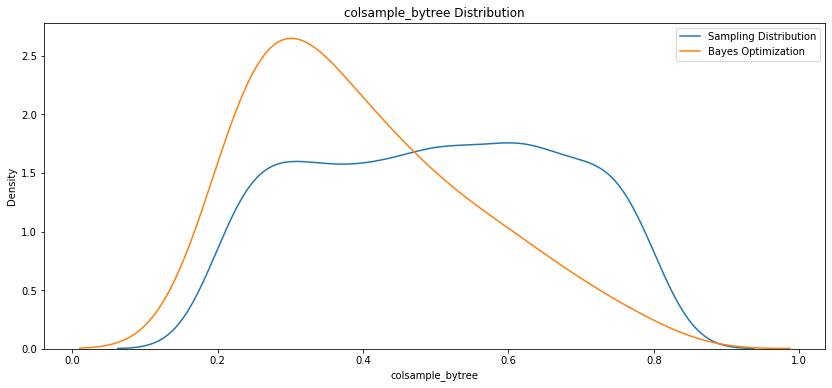

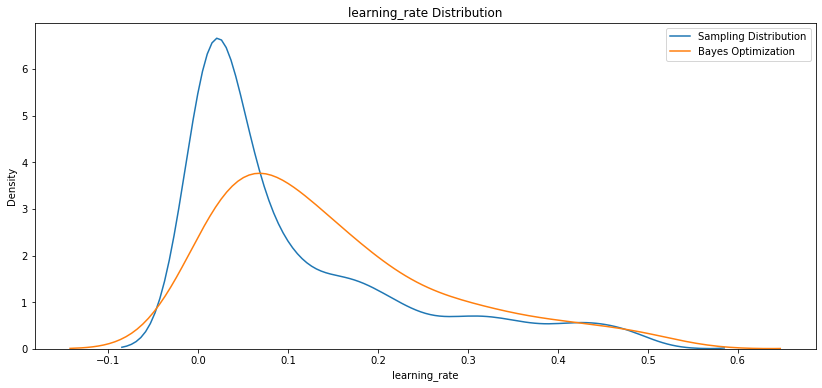

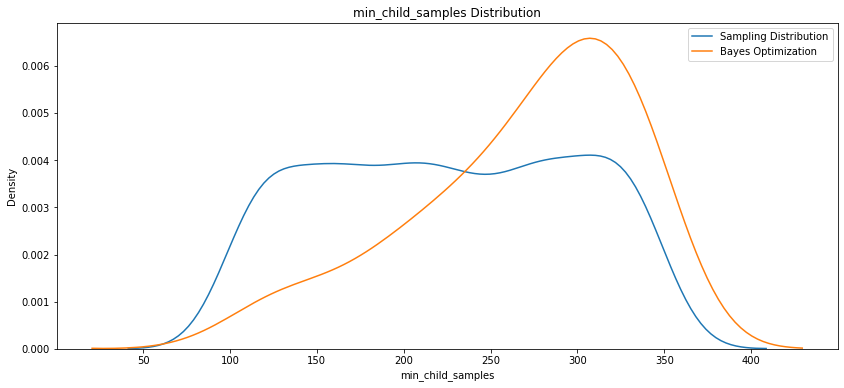

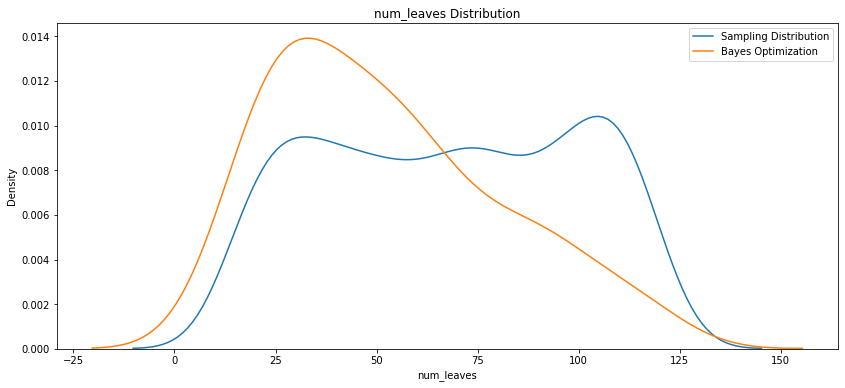

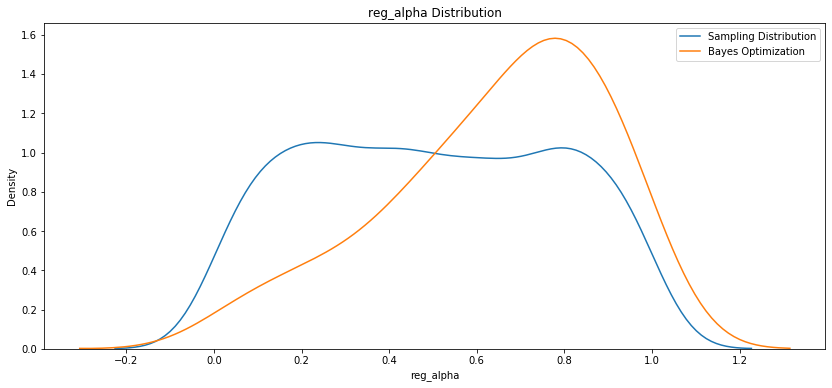

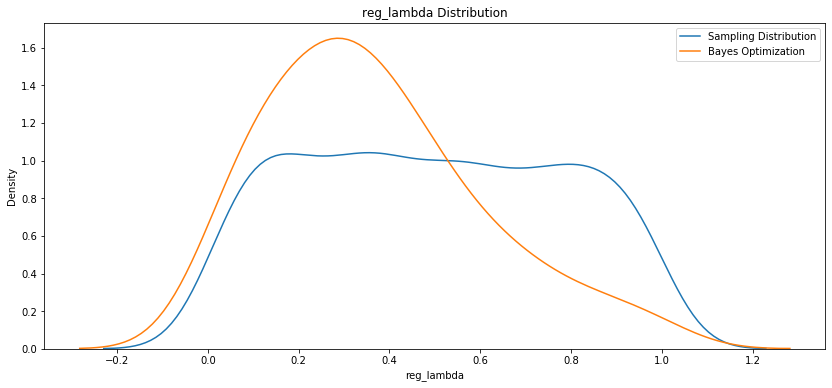

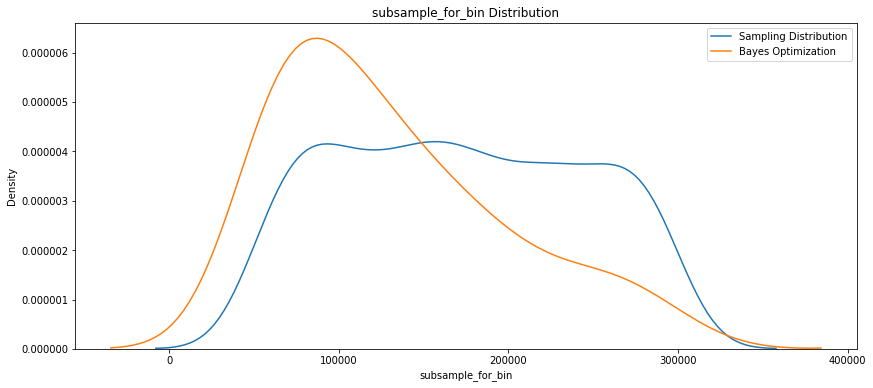

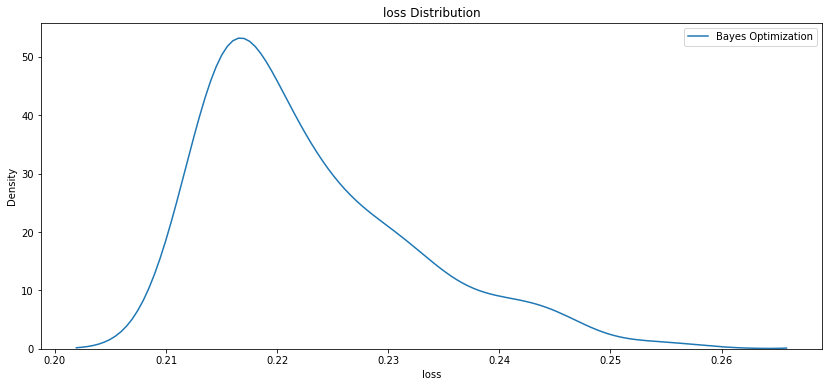

In [14]:
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.5))}

learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])

# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Iterate through each hyperparameter
for i, hyper in enumerate(bayes_params.columns):
    if hyper not in ['class_weight', 'boosting_type', 'iteration', 'subsample', 'metric', 'verbose', 'device']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hyper != 'loss':
            sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution')
        sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization')
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.show();

In [15]:
bayes_params

,boosting_type,class_weight,colsample_bytree,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,device,loss,iteration
0,gbdt,None,0.363843,0.116239,301,50,0.777856,0.312406,50000,0.934417,gpu,0.213507,31
1,gbdt,None,0.253154,0.187067,338,21,0.767002,0.31363,50000,0.905689,gpu,0.213717,28
2,gbdt,None,0.21385,0.15292,334,28,0.807692,0.155669,110000,0.918346,gpu,0.213753,67
3,gbdt,None,0.338447,0.109289,314,48,0.263512,0.325563,60000,0.836174,gpu,0.213903,80
4,gbdt,None,0.221523,0.153618,338,20,0.779702,0.188265,110000,0.899217,gpu,0.213919,23
5,gbdt,None,0.207866,0.120956,330,33,0.887386,0.148904,70000,0.913218,gpu,0.214044,69
6,gbdt,None,0.312693,0.182017,349,19,0.859447,0.143407,110000,0.756944,gpu,0.214087,24
7,gbdt,None,0.251672,0.165804,285,27,0.803026,0.28105,100000,0.988237,gpu,0.214118,68
8,gbdt,balanced,0.480774,0.0893388,302,81,0.922285,0.296729,70000,0.783239,gpu,0.214177,42
9,gbdt,None,0.202752,0.156112,349,18,0.00926349,0.22975,120000,0.805291,gpu,0.214250,22


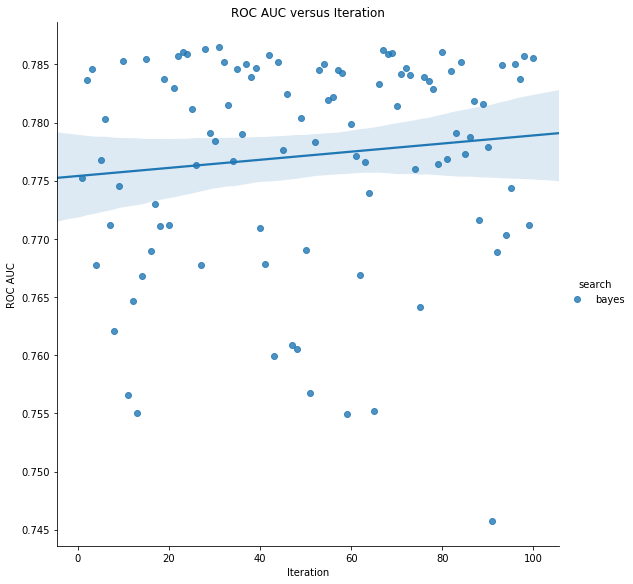

In [16]:
# Dataframe of just scores
scores = pd.DataFrame({'ROC AUC': 1 - bayes_params['loss'], 'iteration': bayes_params['iteration'], 'search': 'bayes'})

scores['ROC AUC'] = scores['ROC AUC'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

scores.head()

# Plot of scores over the course of searching
sns.lmplot('iteration', 'ROC AUC', hue = 'search', data = scores, height = 8);
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("ROC AUC versus Iteration");

In [18]:
fi_df = {}
for name, fi_feat in zip(list(train.columns), best_bayes_model.feature_importances_):
    fi_df[name] = fi_feat
fi_df = pd.DataFrame(pd.Series(fi_df), columns=['FI'])
fi_df.sort_values(by='FI', ascending=False)

,FI
ORGANIZATION_TYPE,171
PAYMENT_RATE,165
EXT_SOURCE_1,122
EXT_SOURCE_2,92
EXT_SOURCE_3,82
OCCUPATION_TYPE,66
DAYS_CREDIT_max,63
DAYS_LAST_DUE_1ST_VERSION_max,60
DAYS_BIRTH,60
AMT_ANNUITY,55
